Price Optimisation Priject

In [28]:
# Data analysis
import pandas as pd
import numpy as np

## Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, f, l
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.express as px
from plotnine import *
import pytimetk as tk
import textwrap

In [29]:
# Load Data
data = pd.read_csv(r"C:\Users\c7810\桌面\Price Optimisation\PhoneCase_Sales.csv")

display(data)

,product,price,quantity_sold,event
0,Standard Case | OOXXphone Pro Max,20.50,772,No Promo
1,Premium Case | OOXXphone Pro,37.32,405,No Promo
2,Premium Case | OOXXphone Pro Max,40.71,317,No Promo
3,Premium Case | OOXXphone Pro Max,43.49,332,No Promo
4,Premium Case | OOXXphone Pro Max,59.70,314,The Big Game
...,...,...,...,...
795,Standard Case | OOXXphone Pro Max,39.98,501,No Promo
796,Standard Case | OOXXphone Pro Max,22.43,715,No Promo
797,Premium Case | OOXXphone Pro Max,47.27,294,No Promo
798,Standard Case | OOXXphone Pro Max,43.05,523,No Promo


In [30]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product,800,4,Standard Case | OOXXphone Pro,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,800.0,NaN,NaN,NaN,41.564075,16.221425,10.61,28.5875,39.6,53.1075,74.97
quantity_sold,800.0,NaN,NaN,NaN,491.59,239.759829,104.0,290.75,479.0,664.25,1549.0
event,800,5,No Promo,692,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data Preparation

In [31]:
# 2.0 DATA PREPARATION
# Track special events vs standard days
data['is_event'] = (data['event'] != 'No Promo').astype(int).astype(str)

# Historical revenue calculation
data['revenue'] = data['price'] * data['quantity_sold']

display(data)

,product,price,quantity_sold,event,is_event,revenue
0,Standard Case | OOXXphone Pro Max,20.50,772,No Promo,0,15826.00
1,Premium Case | OOXXphone Pro,37.32,405,No Promo,0,15114.60
2,Premium Case | OOXXphone Pro Max,40.71,317,No Promo,0,12905.07
3,Premium Case | OOXXphone Pro Max,43.49,332,No Promo,0,14438.68
4,Premium Case | OOXXphone Pro Max,59.70,314,The Big Game,1,18745.80
...,...,...,...,...,...,...
795,Standard Case | OOXXphone Pro Max,39.98,501,No Promo,0,20029.98
796,Standard Case | OOXXphone Pro Max,22.43,715,No Promo,0,16037.45
797,Premium Case | OOXXphone Pro Max,47.27,294,No Promo,0,13897.38
798,Standard Case | OOXXphone Pro Max,43.05,523,No Promo,0,22515.15


Expolratory data analysis

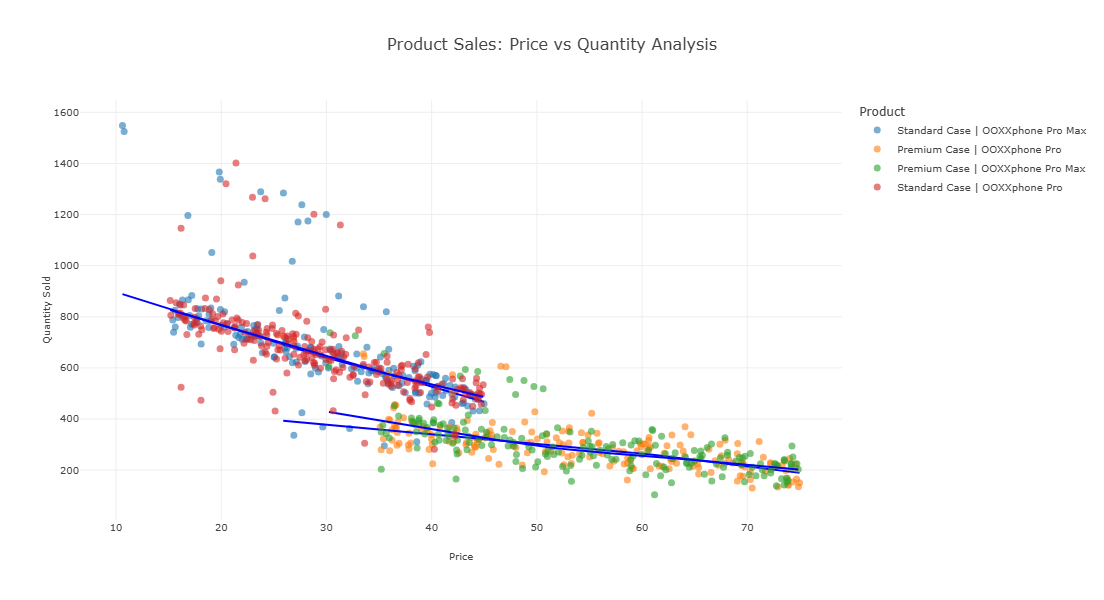

In [32]:
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color='product',
    opacity=0.6,
    trendline='lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Price vs Quantity Analysis',
    width=800,
    height=600,
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
).update_layout(
    legend_title_text='Product',
    title_font=dict(size=16),
    legend_font=dict(size=10),
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
).update_yaxes(
        title_text="Quantity Sold",
        title_font=dict(size=10),
        tickfont=dict(size=10),
)

fig

Event analysis outliers

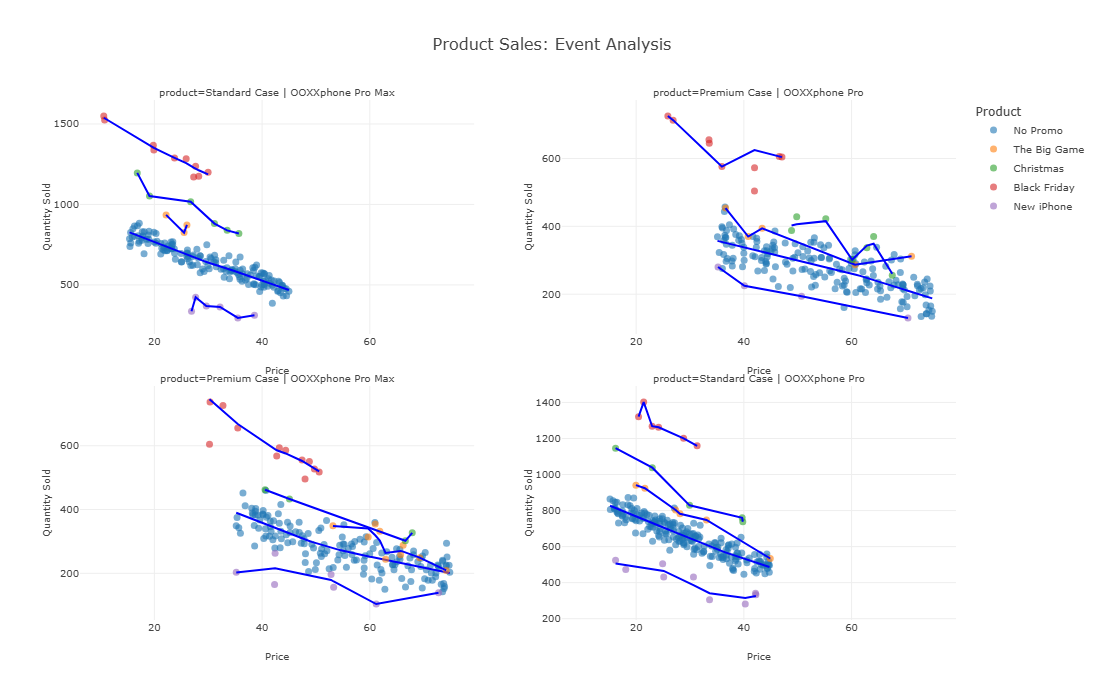

In [35]:
#Scatter plot
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color='event',
    facet_col='product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline='lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Event Analysis',
    width=800,
    height=700,
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10)),
).update_layout(
    legend_title_text='Product',
    title_font=dict(size=16),
    legend_font=dict(size=10),
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10),
).update_yaxes(
        title_text="Quantity Sold",
        title_font=dict(size=10),
        tickfont=dict(size=10),
        matches=None,
)

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

fig

Modeling event impact

In [38]:
df_encoded = data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], drop_first=False)

colnames_event=df_encoded.columns[df_encoded.columns.str.startswith('event')].tolist()

df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

colnames_product =df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()

df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

display(df_encoded)

,price,quantity_sold,is_event,revenue,event_Black Friday,event_Christmas,event_New iPhone,event_No Promo,event_The Big Game,product_Premium Case | OOXXphone Pro,product_Premium Case | OOXXphone Pro Max,product_Standard Case | OOXXphone Pro,product_Standard Case | OOXXphone Pro Max
0,20.50,772,0,15826.00,0,0,0,1,0,0,0,0,1
1,37.32,405,0,15114.60,0,0,0,1,0,1,0,0,0
2,40.71,317,0,12905.07,0,0,0,1,0,0,1,0,0
3,43.49,332,0,14438.68,0,0,0,1,0,0,1,0,0
4,59.70,314,1,18745.80,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,39.98,501,0,20029.98,0,0,0,1,0,0,0,0,1
796,22.43,715,0,16037.45,0,0,0,1,0,0,0,0,1
797,47.27,294,0,13897.38,0,0,0,1,0,0,1,0,0
798,43.05,523,0,22515.15,0,0,0,1,0,0,0,0,1


In [40]:
X =df_encoded[['price'] + colnames_event + colnames_product]
X =sm.add_constant(X) 
y=df_encoded['quantity_sold']

model = sm.OLS(y,X).fit()

model.summary()

model.params

params_df = pd.DataFrame(model.params).T
params_df

,const,price,event_Black Friday,event_Christmas,event_New iPhone,event_No Promo,event_The Big Game,product_Premium Case | OOXXphone Pro,product_Premium Case | OOXXphone Pro Max,product_Standard Case | OOXXphone Pro,product_Standard Case | OOXXphone Pro Max
0,587.569544,-6.90583,410.325779,212.700241,-180.844821,21.390888,123.997458,38.261538,40.036532,253.541214,255.73026


In [44]:
np.log((params_df['event_Black Friday'] + params_df['const']) /
(params_df['event_No Promo'] + params_df['const']))

0    0.493895
dtype: float64

General Price Optimisation: GAMs
Problem: Prices are non-linear
Solution Use GAMs (Generalized Additive Models)
GAMs are like Linear Regression, but allow for non-linear relationship

In [55]:
# Keep the entire data as data_filtered
data_filtered = data.query('event == "No Promo"')

# Create a list of unique products
unique_products = data_filtered['product'].unique()

# Create an empty dataframe to store the concatenated results
all_gam_results = pd.DataFrame()

# Loop through each product
for product in unique_products:
    # Filter data for the current product
    product_data = data_filtered[data_filtered['product'] == product]

    X = product_data[['price']]
    y = product_data['quantity_sold']

    quantiles =[0.025,0.5,0.975]
    gam_results ={}


    #Fit the GAM model for the filtered data
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q)
        gam.fit(X,y)
        gam_results[f"pred_{q}"] =gam.predict(X)


    # Store the results in a dataframe with index that matches the original data
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate the results column-wise with the original data
    predictions_gam_df = pd.concat([product_data[['price','product','quantity_sold']], predictions_gam], axis=1)

    #concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results,predictions_gam_df],axis=0)
    
display(all_gam_results)

,price,product,quantity_sold,pred_0.025,pred_0.5,pred_0.975
0,20.50,Standard Case | OOXXphone Pro Max,772,710.541891,766.347437,808.683654
5,23.76,Standard Case | OOXXphone Pro Max,697,669.511435,710.160326,749.740115
8,28.51,Standard Case | OOXXphone Pro Max,576,599.201156,651.889410,713.510407
10,33.30,Standard Case | OOXXphone Pro Max,585,557.934838,607.725420,673.695727
18,15.47,Standard Case | OOXXphone Pro Max,739,749.294784,801.760994,870.681070
...,...,...,...,...,...,...
774,23.14,Standard Case | OOXXphone Pro,707,660.632430,726.147081,771.159396
782,19.77,Standard Case | OOXXphone Pro,751,705.470385,775.127436,829.349251
784,16.56,Standard Case | OOXXphone Pro,786,758.951220,805.377487,855.282371
787,19.89,Standard Case | OOXXphone Pro,675,703.620377,773.715532,827.373733


Visualize the GAM Price Model Result

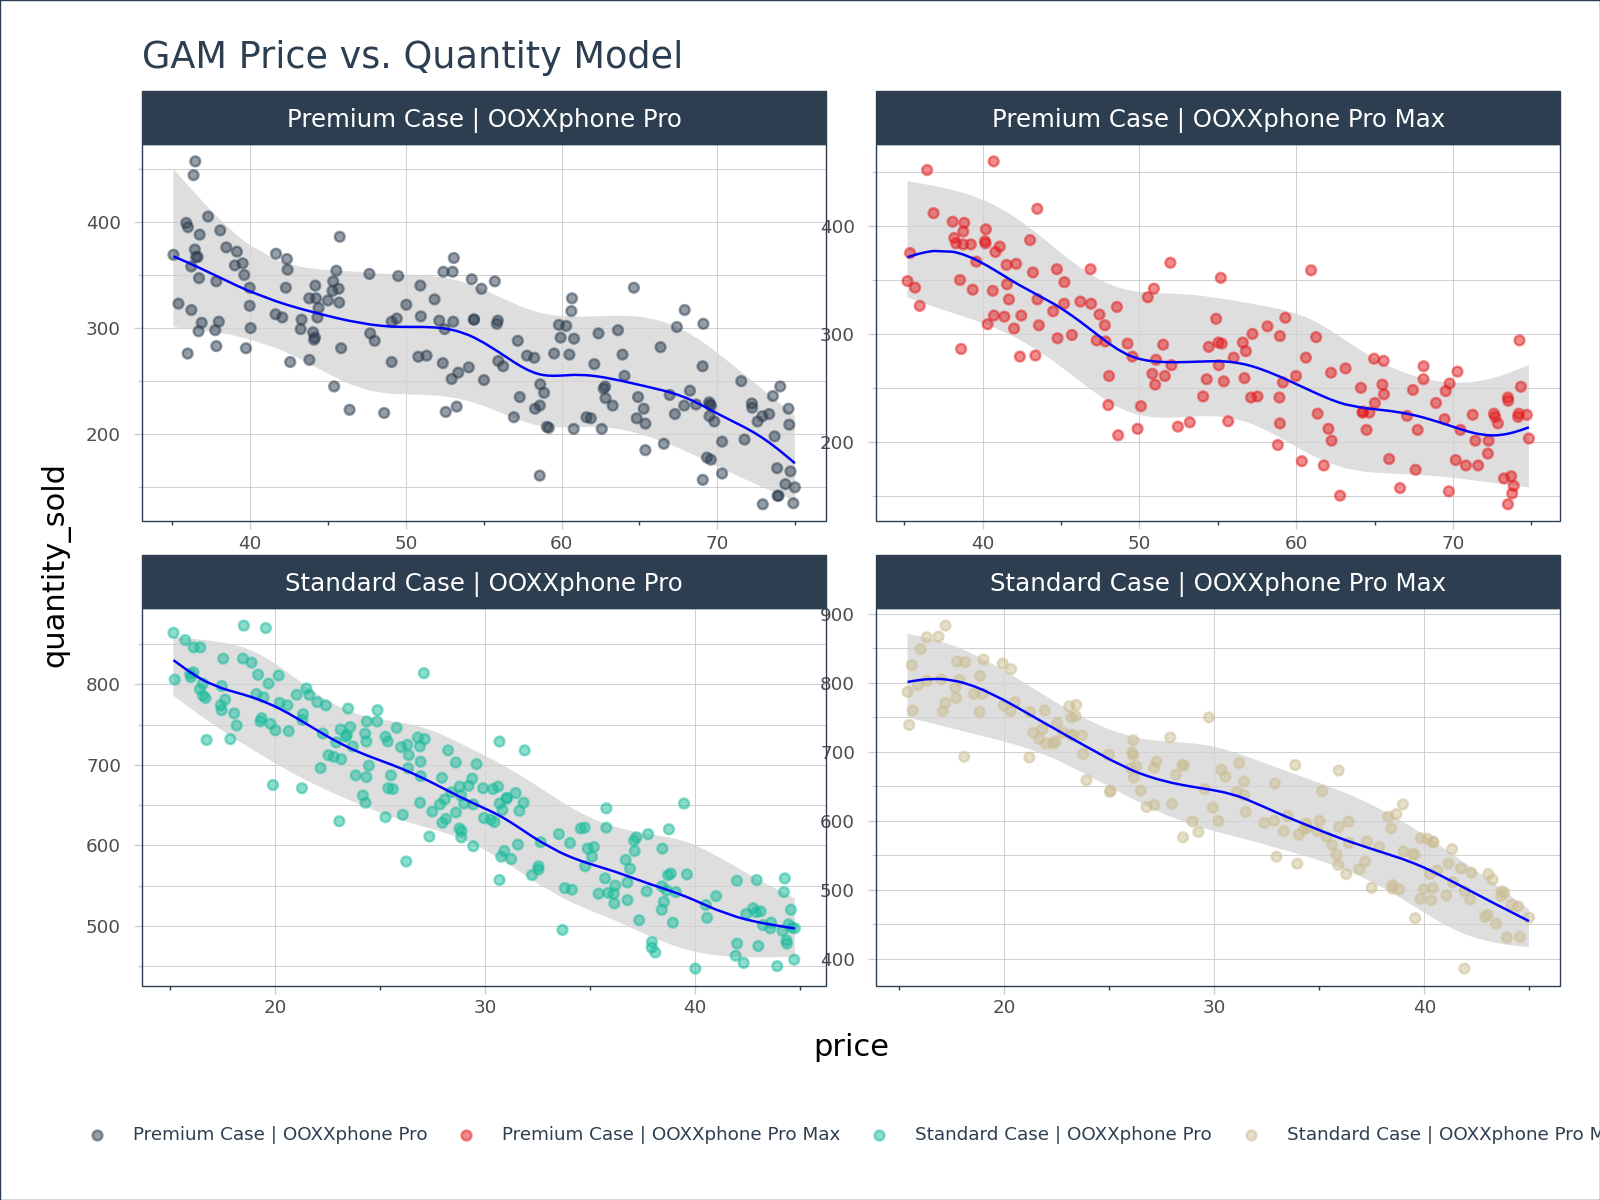

In [60]:
ggplot(
    data = all_gam_results,
    mapping=aes(x='price', y='quantity_sold', color='product',
               group='product'),
    ) + \
    geom_ribbon(aes(ymax ='pred_0.975', ymin ='pred_0.025'), fill=
    "#d3d3d3",color ='#FF000000', alpha=0.75, show_legend=False) + \
    geom_point(alpha=0.5) + \
    geom_line(aes(y='pred_0.5'), color ='blue') + \
    facet_wrap('product', scales='free') + \
    labs(title ='GAM Price vs. Quantity Model') + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width = 800, height =600)

In [61]:
# Optimise price for predicted daily revenue
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_'+col] =all_gam_results['price'] * all_gam_results[col]

all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['quantity_sold']
all_gam_results

,price,product,quantity_sold,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
0,20.50,Standard Case | OOXXphone Pro Max,772,710.541891,766.347437,808.683654,14566.108760,15710.122459,16578.014909,15826.00
5,23.76,Standard Case | OOXXphone Pro Max,697,669.511435,710.160326,749.740115,15907.591704,16873.409334,17813.825140,16560.72
8,28.51,Standard Case | OOXXphone Pro Max,576,599.201156,651.889410,713.510407,17083.224948,18585.367068,20342.181696,16421.76
10,33.30,Standard Case | OOXXphone Pro Max,585,557.934838,607.725420,673.695727,18579.230105,20237.256472,22434.067725,19480.50
18,15.47,Standard Case | OOXXphone Pro Max,739,749.294784,801.760994,870.681070,11591.590307,12403.242571,13469.436150,11432.33
...,...,...,...,...,...,...,...,...,...,...
774,23.14,Standard Case | OOXXphone Pro,707,660.632430,726.147081,771.159396,15287.034432,16803.043455,17844.628415,16359.98
782,19.77,Standard Case | OOXXphone Pro,751,705.470385,775.127436,829.349251,13947.149506,15324.269407,16396.234700,14847.27
784,16.56,Standard Case | OOXXphone Pro,786,758.951220,805.377487,855.282371,12568.232198,13337.051187,14163.476066,13016.16
787,19.89,Standard Case | OOXXphone Pro,675,703.620377,773.715532,827.373733,13995.009306,15389.201934,16456.463558,13425.75


In [63]:
best_50 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.5'] ==x['revenue_pred_0.5'].max()].head(1)) \
    .reset_index(level=0, drop=True)

best_975 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.975'] ==x['revenue_pred_0.975'].max()].head(1)) \
    .reset_index(level=0, drop=True)

best_025 = all_gam_results \
    .groupby('product') \
    .apply(lambda x: x[x['revenue_pred_0.025'] ==x['revenue_pred_0.025'].max()].head(1)) \
    .reset_index(level=0, drop=True)

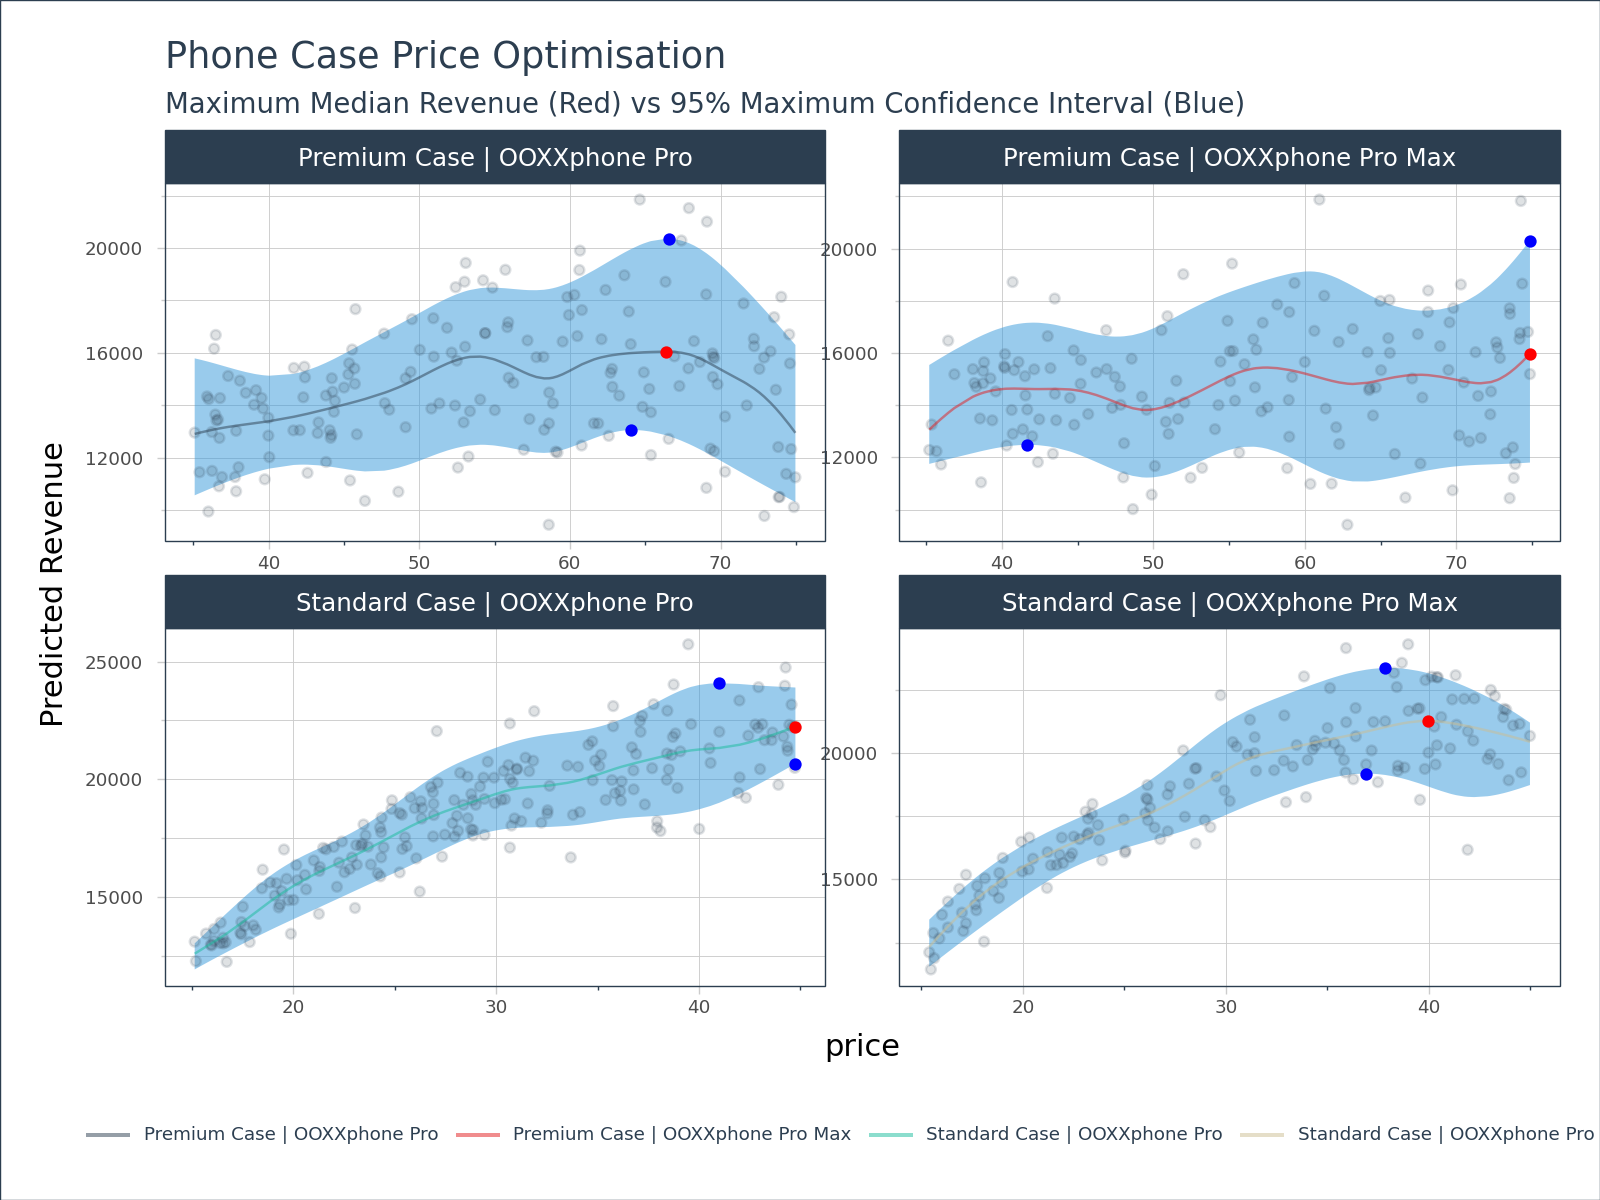

In [75]:
(
  ggplot(
    data = all_gam_results,
    mapping=aes(x='price', y='revenue_pred_0.5', color='product', group='product'),
  ) +
  geom_ribbon(aes(ymax='revenue_pred_0.975', ymin='revenue_pred_0.025'), fill="#3498db", color='#ff000000', alpha=0.5, show_legend=False) +
  geom_point(aes(y='revenue_actual'), alpha=0.15, color='#2C3E50') +
  geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) +
  geom_point(data=best_50, color='red') +
  geom_point(data=best_975, mapping=aes(y='revenue_pred_0.975'), color='blue') +
  geom_point(data=best_025, mapping=aes(y='revenue_pred_0.025'), color='blue') +
  facet_wrap('product', scales='free') +
  labs(
    title='Phone Case Price Optimisation',
    subtitle="Maximum Median Revenue (Red) vs 95% Maximum Confidence Interval (Blue)",
    x='price',
    y='Predicted Revenue'
  ) +
  scale_color_manual(values = list(tk.palette_timetk().values())) +
  tk.theme_timetk(width=800, height=600)
)

In [76]:
best_50[['product','price','revenue_pred_0.5','revenue_pred_0.025','revenue_pred_0.975']]

,product,price,revenue_pred_0.5,revenue_pred_0.025,revenue_pred_0.975
507,Premium Case | OOXXphone Pro,66.35,16044.419341,12856.443808,20351.003329
52,Premium Case | OOXXphone Pro Max,74.85,15971.509399,11802.739700,20312.894486
582,Standard Case | OOXXphone Pro,44.75,22232.407787,20654.812071,23896.481069
795,Standard Case | OOXXphone Pro Max,39.98,21286.545025,18682.701933,23173.364004


In [77]:
# Business Insight
# The GAMS show that the optimal price is at the ends of the price range for Phone Pro Standard case and Phone Pro Max Premium Case
# This suggest that the company should consider a price increase for these models

# The GAMS show that the optimal price is at the price range for Phone Pro Premium case and Phone Pro Max Standard Case
# This suggest that the company should consider a price that is close to the red dots for these products

Modeling GAMS with Events:

In [92]:
data_filtered = data.query('event != "No Promo"')
display(data_filtered)

# Create a list of unique products and events
unique_products = data_filtered['product'].unique()
events_only_gam_results = pd.DataFrame()

# Loop through each product
for product in unique_products:
    # Filter data for the current product and event
    product_event_data = data_filtered[(data_filtered['product'] == product)]
    
    if len(product_event_data) == 0:
        continue  # skip to next iteration if no data for current product-event combination
    
    X = product_event_data[['price', 'event']].copy()  # Use .copy() to avoid SettingWithCopyWarning
    y = product_event_data['quantity_sold']
    
    # NEW: Encode the event column
    le = LabelEncoder()
    X['event'] = le.fit_transform(X['event'])
    
    # NEW: use f(1) to indicate that the event column is categorical 
    gam = GAM(l(0) + f(1))
    gam.fit(X, y)
    
    # Initialize gam_results dictionary
    gam_results = {}
    gam_results["pred_0.5"] = gam.predict(X)
    
    # Store the results in a dataframe with index that matches the original data
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)
    
    # Concatenate the results column-wise with the original data
    predictions_gam_df = pd.concat([product_event_data[['price', 'product', 'event', 'quantity_sold']], predictions_gam], axis=1)
    
    # Concatenate results row-wise
    events_only_gam_results = pd.concat([events_only_gam_results, predictions_gam_df], axis=0)

events_only_gam_results

,product,price,quantity_sold,event,is_event,revenue
4,Premium Case | OOXXphone Pro Max,59.70,314,The Big Game,1,18745.80
14,Premium Case | OOXXphone Pro,64.09,370,Christmas,1,23713.30
30,Premium Case | OOXXphone Pro,41.98,573,Black Friday,1,24054.54
32,Premium Case | OOXXphone Pro,33.58,645,Black Friday,1,21659.10
40,Standard Case | OOXXphone Pro,27.33,803,The Big Game,1,21945.99
...,...,...,...,...,...,...
745,Standard Case | OOXXphone Pro,30.64,432,New iPhone,1,13236.48
746,Premium Case | OOXXphone Pro,50.71,194,New iPhone,1,9837.74
768,Standard Case | OOXXphone Pro Max,26.75,1017,Christmas,1,27204.75
785,Premium Case | OOXXphone Pro Max,69.26,249,The Big Game,1,17245.74


,price,product,event,quantity_sold,pred_0.5
4,59.70,Premium Case | OOXXphone Pro Max,The Big Game,314,312.852099
69,32.74,Premium Case | OOXXphone Pro Max,Black Friday,726,638.512813
82,53.29,Premium Case | OOXXphone Pro Max,New iPhone,156,179.770457
96,72.77,Premium Case | OOXXphone Pro Max,New iPhone,139,67.261113
116,47.98,Premium Case | OOXXphone Pro Max,Black Friday,496,550.492157
...,...,...,...,...,...
557,31.16,Standard Case | OOXXphone Pro Max,Christmas,881,880.965151
603,19.81,Standard Case | OOXXphone Pro Max,Black Friday,1367,1343.848850
669,19.91,Standard Case | OOXXphone Pro Max,Black Friday,1338,1341.905024
698,27.67,Standard Case | OOXXphone Pro Max,New iPhone,424,468.012932


In [85]:
display(events_only_gam_results)

,price,product,event,quantity_sold,pred_0.5
4,59.70,Premium Case | OOXXphone Pro Max,The Big Game,314,312.852099
69,32.74,Premium Case | OOXXphone Pro Max,Black Friday,726,638.512813
82,53.29,Premium Case | OOXXphone Pro Max,New iPhone,156,179.770457
96,72.77,Premium Case | OOXXphone Pro Max,New iPhone,139,67.261113
116,47.98,Premium Case | OOXXphone Pro Max,Black Friday,496,550.492157
...,...,...,...,...,...
557,31.16,Standard Case | OOXXphone Pro Max,Christmas,881,880.965151
603,19.81,Standard Case | OOXXphone Pro Max,Black Friday,1367,1343.848850
669,19.91,Standard Case | OOXXphone Pro Max,Black Friday,1338,1341.905024
698,27.67,Standard Case | OOXXphone Pro Max,New iPhone,424,468.012932


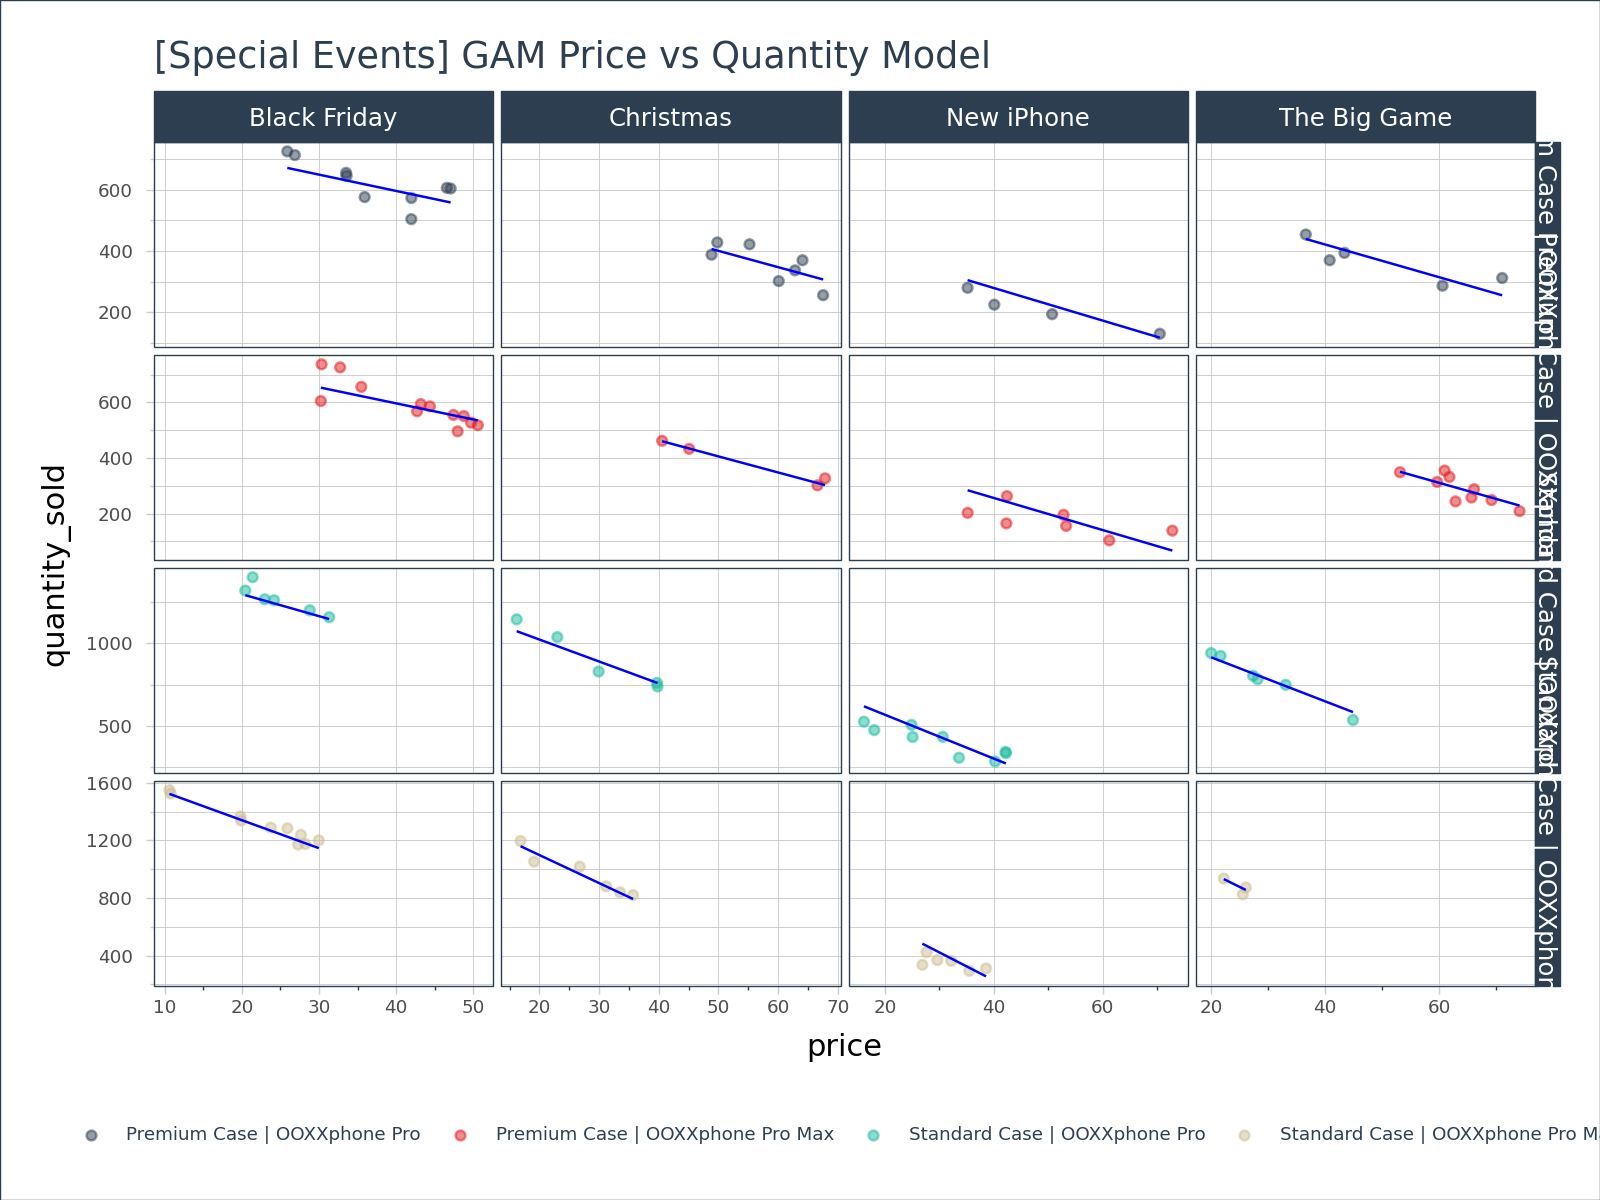

In [86]:
# Visualize the GAM Price Model Results
ggplot(
    data = events_only_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product'),
) + \
geom_point(alpha=0.5) + \
geom_line(aes(y = "pred_0.5"), color = "blue") + \
facet_grid('product ~ event', scales = "free") + \
labs(title = "[Special Events] GAM Price vs Quantity Model") + \
scale_color_manual(values = list(tk.palette_timetk().values())) + \
tk.theme_timetk(width = 800, height = 600)

In [91]:
# THEN OPTIMIZE PRICE FOR PREDICTED DAILY REVENUE

# Optimize Price for Predicted Daily Revenue

for col in events_only_gam_results.columns:
    if col.startswith('pred'):
        events_only_gam_results['revenue_' + col] \
        = events_only_gam_results['price'] * events_only_gam_results[col]

events_only_gam_results

best_50 = events_only_gam_results \
    .groupby(['product', 'event']) \
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)) \
    .reset_index(level=0, drop=True)

display(best_50)



,,price,product,event,quantity_sold,pred_0.5,revenue_pred_0.5
event,,,,,,,
Black Friday,447,47.07,Premium Case | OOXXphone Pro,Black Friday,604,558.418941,26284.779553
Christmas,71,62.84,Premium Case | OOXXphone Pro,Christmas,337,332.302865,20881.912063
New iPhone,746,50.71,Premium Case | OOXXphone Pro,New iPhone,194,222.514689,11283.719889
The Big Game,449,60.64,Premium Case | OOXXphone Pro,The Big Game,287,311.474729,18887.827577
Black Friday,213,50.60,Premium Case | OOXXphone Pro Max,Black Friday,518,535.359996,27089.215823
Christmas,214,66.60,Premium Case | OOXXphone Pro Max,Christmas,302,310.019878,20647.323876
New iPhone,544,42.32,Premium Case | OOXXphone Pro Max,New iPhone,165,243.129158,10289.225957
The Big Game,4,59.70,Premium Case | OOXXphone Pro Max,The Big Game,314,312.852099,18677.270340
Black Friday,304,31.32,Standard Case | OOXXphone Pro,Black Friday,1159,1147.777537,35948.392461


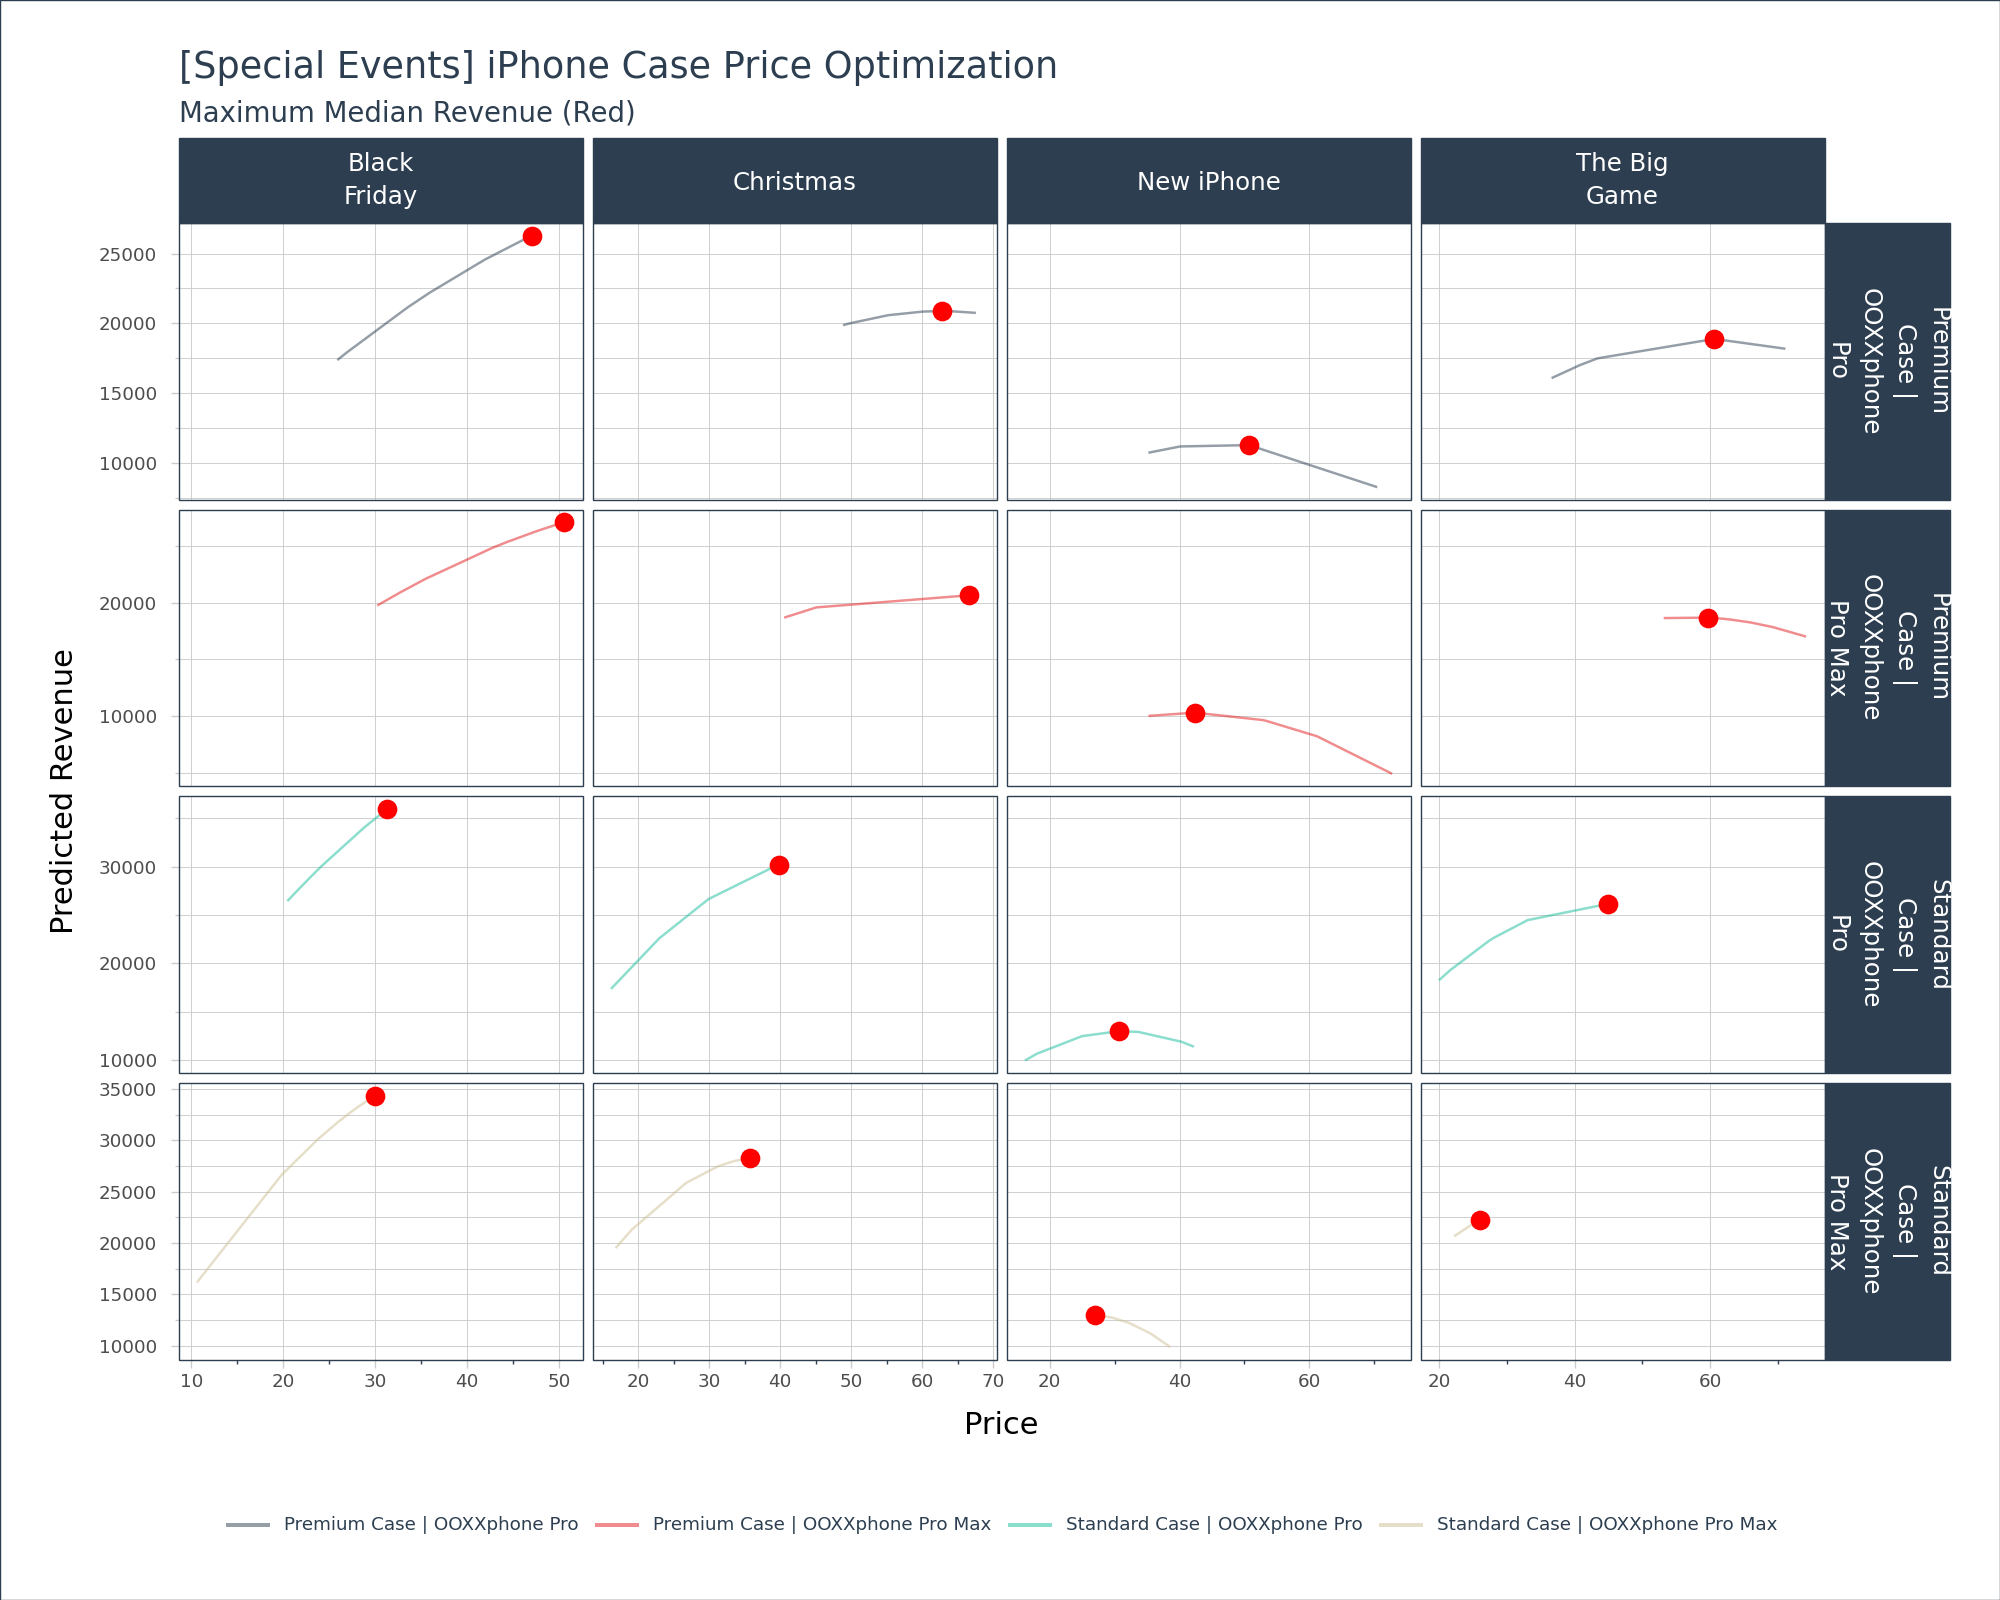

In [90]:
# Visualize the GAM Revenue Optimization Results

# Define the wrap function
def wrap_label(label, width=10):
    return '\n'.join(textwrap.wrap(label, width=width))

ggplot(
    data = events_only_gam_results,
    mapping = aes(x='price', y='revenue_pred_0.5', color='product'),
) + \
geom_line(alpha=0.5) + \
geom_point(data=best_50, color='red', size=3) + \
facet_grid('product ~ event', scales='free', labeller=lambda x: wrap_label(x)) + \
labs(
    title='[Special Events] iPhone Case Price Optimization',
    subtitle='Maximum Median Revenue (Red)',
    x='Price',
    y='Predicted Revenue'
) + \
scale_color_manual(values = list(tk.palette_timetk().values())) + \
tk.theme_timetk(width = 1000, height = 800)